# BBH detection using a CNN

This example shows some of the methodology used in the [Matching matched filtering](https://arxiv.org/abs/1712.06041) paper.

Some elements have been simplified to decrease runtime. For access to the data please contact me.

In [1]:
# imports
from __future__ import print_function

import numpy as np
import cPickle as pickle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Dataset

The dataset in the paper consited on 500,000 training samples. It contained 20,000 unique signals each with 25 different noise realisations for a total of 250,000 signal timeseries and 250,000 background timeseries. The validation and testing sets were 50,000 time series each, with a 50/50 split single/background. Each SNR had this same data structure.

The aim is to classify the time series into signal or background.

We are looking for signals that look something like this:
<img src="./images/waveform.png" alt="waveform" width="500px"/>

Let's load the data and look at what we are dealing with. This example will used a reduced dataset for only one SNR (8).

In [2]:
training_data = './data/bbh/BBH_training_1s_8192Hz_10Ksamp_25n_iSNR8_Hdet_metricmass_158seed_ts_0.sav'
validation_data = './data/bbh/BBH_validation_1s_8192Hz_10Ksamp_1n_iSNR8_Hdet_metricmass_107seed_ts_0.sav'
testing_data = './data/bbh/BBH_testing_1s_8192Hz_10Ksamp_1n_iSNR8_Hdet_metricmass_117seed_ts_0.sav'
ts_length = 8192    # set the length we want out time series to be

There are datasets for training, testing and validation

In [3]:
def load_data(data_file, start=4096, length=8192):
    """Load the data and remove the first and last 0.5 seconds"""
    with open(data_file, 'rb') as f:
        x, y = pickle.load(f)
    # ts are 16384 long, so want middle 8192 samples
    x = x[:,:,start:(start+length)]
    print('x shape: {0}, y shape: {1}'.format(x.shape, y.shape))
    return x,y

In [4]:
x_train, y_train = load_data(training_data)

x shape: (10000, 1, 8192), y shape: (10000,)


In [78]:
x_val, y_val = load_data(validation_data)

x shape: (10000, 1, 8192), y shape: (10000,)


In [79]:
x_test, y_test = load_data(testing_data)

x shape: (10000, 1, 8192), y shape: (10000,)


Here the 'x' arrays are the time series and the 'y' the labels, that look something like this:
```
[0 1 0 1 0 0 0 1 1 0]
```
We can plot a few of the time series to see what they look like

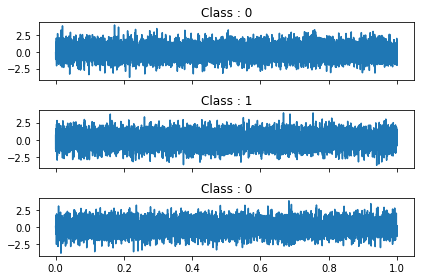

In [12]:
fig, axs = plt.subplots(3,1, sharex = True)
axs = axs.ravel()
t = np.linspace(0,1, ts_length)
for i in range(len(axs)):
    axs[i].plot(t, x_train[i,0,:])
    axs[i].set_title('Class : {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

### General parameters

We need to define some general parameters for networks we're going to use

In [100]:
batch_size = 32      # number of time series per batch
num_classes = 2      # signal or background
epochs = 2          # number of full passes of the dataset
outdir = './results' # directory to store results in

## CNN

This example uses a deep CNN (more than 1 layer). It has a similar architecture to that used in the paper, but is slightly reduced for quicker training

There are different ways to order the dimensions of the data, in the case we will setting the channels (think RBG in images) as the first input

In [56]:
keras.backend.set_image_data_format('channels_first')

We then need to reshape the data to fit the network setup

In [90]:
# reshape data
x_train = x_train.reshape(-1, 1, 1, ts_length)
x_val = x_val.reshape(-1, 1, 1, ts_length)
x_test = x_test.reshape(-1, 1, 1, ts_length)
# get input shape for first layer of network
input_shape = x_train.shape[1:]

In [83]:
# convert class vectors to binary class matrices
# (do not run twice as it will perform the same operation again)
if len(y_train.shape)==1:
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

Now the labels for the time series looks like this:
```
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)
```


### The Model

In [104]:
model = Sequential()    # define the type of keras model

# add the layers
# conv1
model.add(Conv2D(8, (1,64), activation='elu', input_shape=input_shape))
model.add(BatchNormalization(axis=1))
# conv2
model.add(Conv2D(8, (1,32), activation='elu'))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((1,8)))
# conv3
model.add(Conv2D(16, (1,32), activation='elu'))
model.add(BatchNormalization(axis=1))
# conv4
model.add(Conv2D(16, (1,16), activation='elu'))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((1,6)))
# the input the fully connected layer must be 1-D vector
model.add(Flatten())
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.5))
# add the output layer with softmax actiavtion for classication
model.add(Dense(num_classes, activation='softmax'))
# print a summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 8, 1, 8129)        520       
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 1, 8129)        32        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 1, 8098)        2056      
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 1, 8098)        32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 1, 1012)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 1, 981)        4112      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 1, 981)        64        
__________

### Compile
Here we use the Nadam optimizer with default values specified in the intial [report](http://cs229.stanford.edu/proj2015/054_report.pdf).

The loss function with be categorical crossentropy as we are dealing with a classifaction problem. It is defined as:

$$
 f(\theta) = - \sum_{i \in S} \log(\theta_{i}^{S}) - \sum_{i \in N} \log(\theta_{i}^{N})
$$

where $\theta_{i}^{S/N}$ refer to the predicted probability of class signal+noise (S) or noise-only(N) for the $i$'th training sample

In [98]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(),
              metrics=['accuracy'])

### The Training

In [96]:
# save the model each epoch if it is the best so far
modelCheck = ModelCheckpoint('{0}/best_weights.hdf5'.format(outdir), monitor='val_acc', verbose=0, 
                save_best_only=True,save_weights_only=True, mode='auto', period=0)

In [101]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks = [modelCheck]
                   )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 515s 51ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
 2528/10000 [======>.......................] - ETA: 4:17 - loss: 8.0272 - acc: 0.5020

KeyboardInterrupt: 

### Evaluating the model

In [ ]:
# load the best model
model.load_weights('{0}/best_weights.hdf5'.format(outdir))
# evaluate
eval_results = model.evaluate(x_test, y_test,
                              sample_weight=None,
                              batch_size=batch_size, verbose=1)

In [ ]:
# get the predictions
y_preds = model.predict(x_test)

## Analysing the results

[scikit-learn](http://scikit-learn.org/stable/) is a useful tool for analysis the results

In [35]:
from sklearn import metrics
import itertools

### ROC curve

Reciever operating characteristic (ROC) curves are a useful way to visualize the perfomance of a classifier at different acceptance thresholds

In [36]:
fa, ta, _ = metrics.roc_curve(y_test, y_preds)

NameError: name 'y_test' is not defined

In [37]:
fig = plt.figure()
plt.plot(fa, ta,)
ply.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.show()

NameError: name 'fp' is not defined

<Figure size 432x288 with 0 Axes>

From here the accuracy for a given false alarm probability(FAP) can be calculated. If the process is then repeated for various FAPs and SNRs, a plot like the one shown in the paper can be produced:

<img src="./images/accuracy.png" alt="acc" width="500px"/>

### Confusion matrix

Confusion matrices are useful in classification for checking if the classifier is underperforming for a particular class

In [102]:
# function taken from scikit-learn examples
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
# cm needs predicted class, rather than probability
y_preds_class = np.argmax(y_preds, axis =1)

NameError: name 'y_preds' is not defined

In [49]:
cm = metrics.confusion_matrix(y_test[:,1], y_preds_class)

NameError: name 'y_test' is not defined

In [50]:
plot_confusion_matrix(cm, ['background', 'signal'], normalize=True)

NameError: name 'cm' is not defined